<h1>Kaggle Predict the Introverts from the Extroverts</h1>
<h3>Playground Series - Season 5, Episode 7</h3>

<h2>Import libraries</h2>

In [114]:
# Standard data manipulation and numerical computing
import pandas as pd
import numpy as np
from collections import Counter

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Model selection and evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

# Metrics for model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Baseline model
from sklearn.dummy import DummyClassifier

import xgboost as xgb
from scipy.stats import uniform, randint
import lightgbm as lgb
import joblib

In [115]:
path = './dataset/'
print(path)

./dataset/


In [116]:
train = pd.read_csv(path + 'train.csv')
test  = pd.read_csv(path + 'test.csv')

In [4]:
train.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [117]:
def detect_outliers(df,n,features):
    outlier_indices = []

    for col in features:
        Q1 = np.percentile(df[col],25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k,v in outlier_indices.items() if v > n)

    return multiple_outliers

Otliers_to_drop = detect_outliers(train,2,['Time_spent_Alone','Social_event_attendance','Going_outside','Friends_circle_size','Post_frequency'])

<h2>Some statistics</h2>


In [118]:
train.loc[Otliers_to_drop]

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality


In [119]:
train_len = len(train)
dataset = pd.concat(objs=[train,test], axis=0)
dataset = dataset.drop('id', axis=1).reset_index(drop=True)
len(dataset)

24699

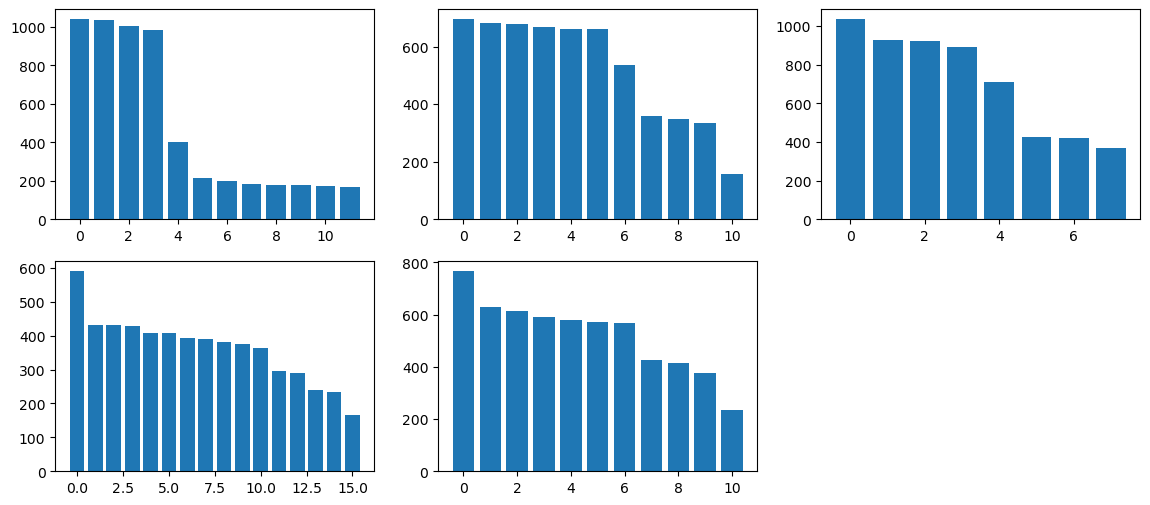

In [8]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3,figsize=(14,6))
ax1.bar(np.arange(test['Time_spent_Alone'].max() + 1),test['Time_spent_Alone'].value_counts())
ax2.bar(np.arange(test['Social_event_attendance'].max() + 1),test['Social_event_attendance'].value_counts())
ax3.bar(np.arange(test['Going_outside'].max() + 1),test['Going_outside'].value_counts())
ax4.bar(np.arange(test['Friends_circle_size'].max() + 1),test['Friends_circle_size'].value_counts())
ax5.bar(np.arange(test['Post_frequency'].max() + 1),test['Post_frequency'].value_counts())
ax6.set_visible(False)

<h2>Fill missing values</h2>

In [120]:
dataset.fillna(np.nan)
print(dataset.isnull().sum())
test.head()
len(test)

Time_spent_Alone             1615
Stage_fear                   2491
Social_event_attendance      1577
Going_outside                1932
Drained_after_socializing    1581
Friends_circle_size          1404
Post_frequency               1672
Personality                  6175
dtype: int64


6175

In [10]:
train.describe()

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,5.265106,4.044319,7.996737,4.982097
std,5347.562529,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,9261.500000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,13892.250000,4.000000,8.000000,6.000000,12.000000,7.000000
max,18523.000000,11.000000,10.000000,7.000000,15.000000,10.000000


In [11]:
train.dtypes

id                             int64
Time_spent_Alone             float64
Stage_fear                    object
Social_event_attendance      float64
Going_outside                float64
Drained_after_socializing     object
Friends_circle_size          float64
Post_frequency               float64
Personality                   object
dtype: object

In [121]:
train['Personality'] = train['Personality'].map({'Extrovert':1, 'Introvert':0})

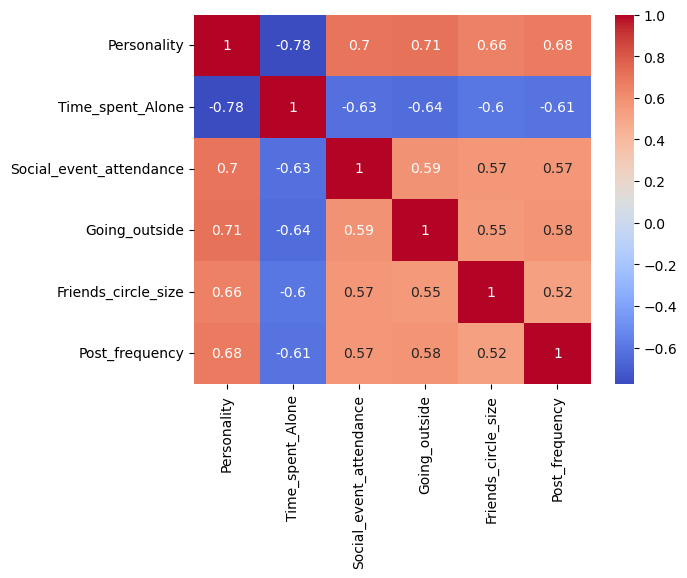

In [13]:
g = sns.heatmap(train[['Personality','Time_spent_Alone','Social_event_attendance','Going_outside',
                      'Friends_circle_size','Post_frequency']].corr(), cmap='coolwarm',annot=True)

/tmp/ipykernel_4946/2282410519.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x="Time_spent_Alone", y="Personality", data=train, kind="bar", palette="muted")


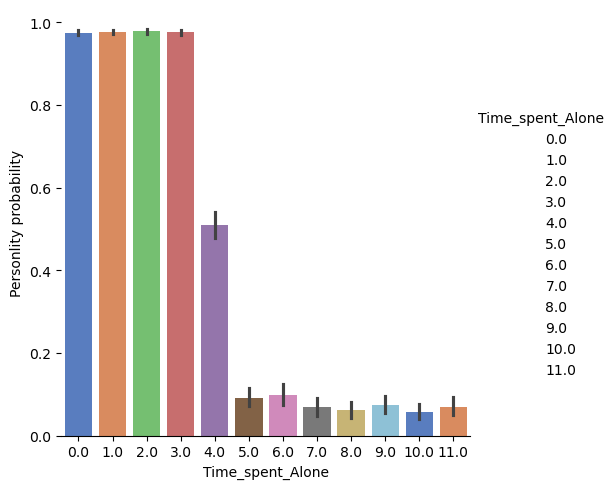

In [14]:
g = sns.catplot(x="Time_spent_Alone", y="Personality", data=train, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Personlity probability")

/tmp/ipykernel_4946/2325870038.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=train, x="Social_event_attendance", y="Personality", kind="bar", palette="muted")


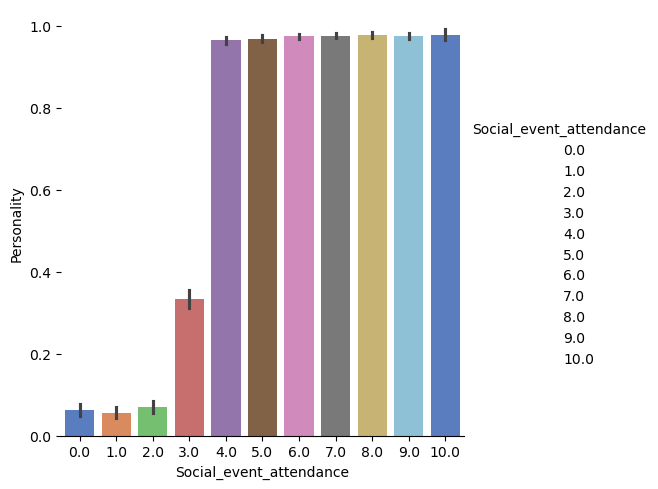

In [15]:
g = sns.catplot(data=train, x="Social_event_attendance", y="Personality", kind="bar", palette="muted")
g.despine(left=True)

/tmp/ipykernel_4946/844689958.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=train, x="Going_outside", y="Personality", kind="bar", palette="muted")


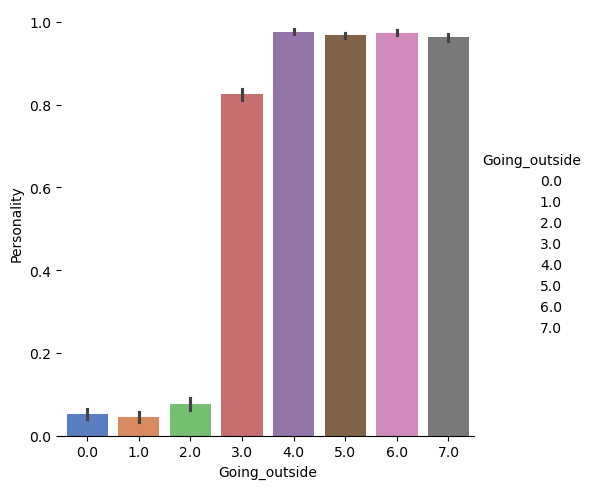

In [16]:
g = sns.catplot(data=train, x="Going_outside", y="Personality", kind="bar", palette="muted")
g.despine(left=True)

/tmp/ipykernel_4946/3473263060.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=train, x="Friends_circle_size", y="Personality", kind="bar", palette="muted")


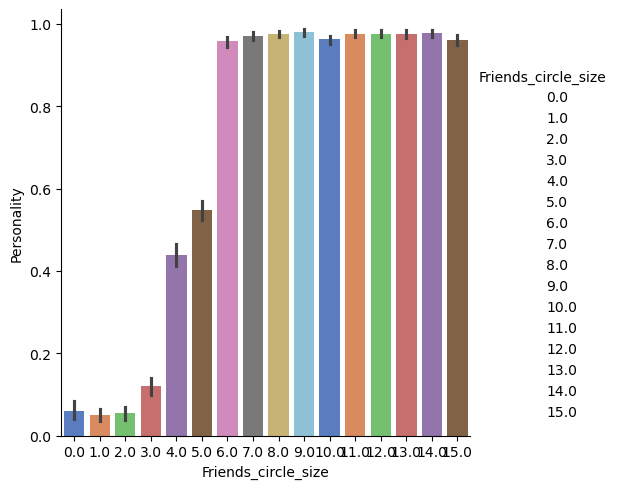

In [17]:

sns.catplot(data=train, x="Friends_circle_size", y="Personality", kind="bar", palette="muted")
g.despine(left=True)


/tmp/ipykernel_4946/4079595151.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=train, x="Post_frequency", y="Personality", kind="bar", palette="muted")


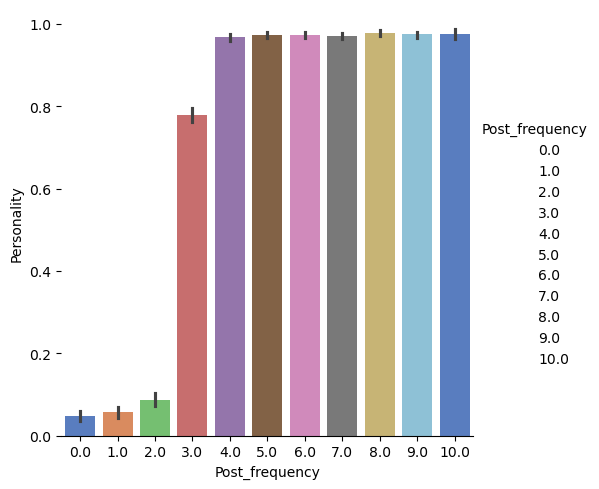

In [18]:
g = sns.catplot(data=train, x="Post_frequency", y="Personality", kind="bar", palette="muted")
g.despine(left=True)

/tmp/ipykernel_4946/3475844019.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(data=train, x="Stage_fear", y="Personality", palette="muted")


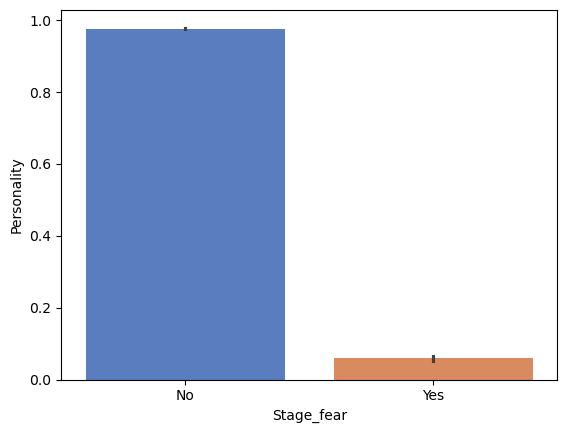

In [19]:
g = sns.barplot(data=train, x="Stage_fear", y="Personality", palette="muted")

/tmp/ipykernel_4946/1194766343.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(data=train, x="Drained_after_socializing", y="Personality", palette="muted")


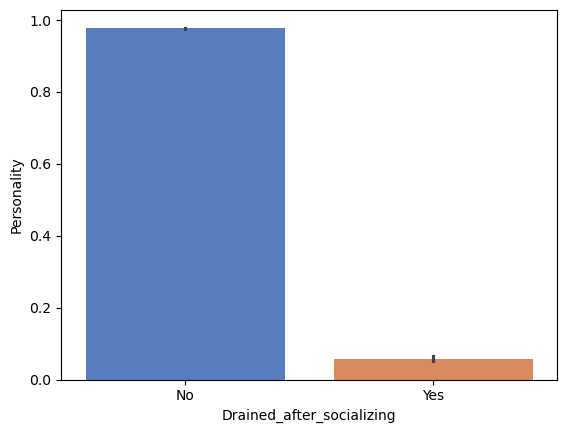

In [20]:
g = sns.barplot(data=train, x="Drained_after_socializing", y="Personality", palette="muted")

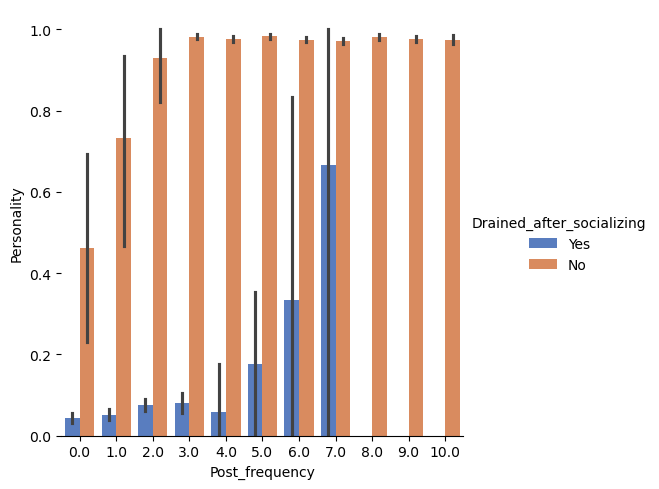

In [21]:
g = sns.catplot(data=train, x="Post_frequency", y="Personality", hue='Drained_after_socializing', kind="bar", palette="muted")
g.despine(left=True)

In [122]:
imputer = SimpleImputer(strategy="median")

In [123]:
y_train = train['Personality']
X_train_num = train.select_dtypes(include=[np.number]).drop(['id','Personality'], axis=1, errors='ignore')
dataset_num = dataset[X_train_num.columns]

In [124]:
imputer.fit(X_train_num)

SimpleImputer(strategy='median')

In [125]:
joblib.dump(imputer, models_path + 'imputer.pkl')

['./dataset/models/imputer.pkl']

In [126]:
X = imputer.transform(dataset_num)

In [127]:
dataset_num_imputed = pd.DataFrame(X, columns=dataset_num.columns)
train_num_imputed = dataset_num_imputed[:len(train)] # used later for training a scaler
len(train_num_imputed)

18524

In [128]:
dataset_num_imputed.head()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
0,0.0,6.0,4.0,15.0,5.0
1,1.0,7.0,3.0,10.0,8.0
2,6.0,1.0,0.0,3.0,0.0
3,3.0,7.0,3.0,11.0,5.0
4,1.0,4.0,4.0,13.0,5.0


In [129]:
dataset_num_imputed.isna().sum()

Time_spent_Alone           0
Social_event_attendance    0
Going_outside              0
Friends_circle_size        0
Post_frequency             0
dtype: int64

In [130]:
X_train_cat = train.select_dtypes(include=[object]).drop(['Personality'], axis=1, errors='ignore')
dataset_cat = dataset[X_train_cat.columns]

In [131]:
dataset_cat.head()

,Stage_fear,Drained_after_socializing
0,No,No
1,No,No
2,Yes,NaN
3,No,No
4,No,No


In [132]:
print(X_train_cat.isna().sum())
print(dataset_cat.isna().sum())

Stage_fear                   1893
Drained_after_socializing    1149
dtype: int64
Stage_fear                   2491
Drained_after_socializing    1581
dtype: int64


In [133]:
imputer_cat = SimpleImputer(strategy="most_frequent")

In [134]:
imputer_cat.fit(X_train_cat)

SimpleImputer(strategy='most_frequent')

In [135]:
joblib.dump(imputer_cat, models_path + 'imputer_cat.pkl')

['./dataset/models/imputer_cat.pkl']

In [136]:
X_cat = imputer_cat.transform(dataset_cat)

In [137]:
dataset_cat_imputed = pd.DataFrame(X_cat, columns=dataset_cat.columns)

In [138]:
dataset_cat_imputed.head()

,Stage_fear,Drained_after_socializing
0,No,No
1,No,No
2,Yes,No
3,No,No
4,No,No


In [139]:
dataset_cat_imputed.isna().sum()

Stage_fear                   0
Drained_after_socializing    0
dtype: int64

In [140]:
cat_encoder = OneHotEncoder()
dataset_cat_1hot = cat_encoder.fit_transform(dataset_cat_imputed)

In [141]:
joblib.dump(cat_encoder, models_path + 'cat_encoder.pkl')

['./dataset/models/cat_encoder.pkl']

In [142]:
dataset_cat_1hot = pd.DataFrame(dataset_cat_1hot.toarray(),columns=cat_encoder.get_feature_names_out())

In [143]:
dataset_cat_1hot.head()

,Stage_fear_No,Stage_fear_Yes,Drained_after_socializing_No,Drained_after_socializing_Yes
0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0
3,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0


In [144]:
scaler = StandardScaler()

In [145]:
scaler.fit(train_num_imputed)

StandardScaler()

In [146]:
joblib.dump(scaler, models_path + 'scaler.pkl')

['./dataset/models/scaler.pkl']

In [43]:
X_fit = scaler.transform(dataset_num_imputed)

In [44]:
dataset_num_std_scaled = pd.DataFrame(X_fit, columns=scaler.get_feature_names_out())

In [45]:
dataset_num_std_scaled.head()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
0,-1.049913,0.282102,-0.020620,1.707463,0.006002
1,-0.707327,0.657346,-0.525859,0.488383,1.085490
2,1.005601,-1.594120,-2.041578,-1.218331,-1.793144
3,-0.022156,0.657346,-0.525859,0.732199,0.006002
4,-0.707327,-0.468387,-0.020620,1.219831,0.006002


<h2>Build dataframe</h2>

In [46]:
dataset_final = pd.DataFrame(pd.merge(dataset_num_std_scaled,dataset_cat_1hot, left_index=True, right_index=True))

In [47]:
# print(dataset_final.head())
print(len(dataset_final))

24699


In [48]:
y_train

0        1
1        1
2        0
3        1
4        1
        ..
18519    1
18520    1
18521    0
18522    0
18523    1
Name: Personality, Length: 18524, dtype: int64

In [49]:
X_train = dataset_final[:len(train)]
X_test = dataset_final[len(train):]
Y_train = y_train # Apply mapping to y_train
Y_train.head()

0    1
1    1
2    0
3    1
4    1
Name: Personality, dtype: int64

In [50]:
kfold = StratifiedKFold(n_splits=5)

/tmp/ipykernel_54358/2005369514.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x="CrossValMeans", y="Algorithm", data=cv_res, palette="Set3", orient="h",


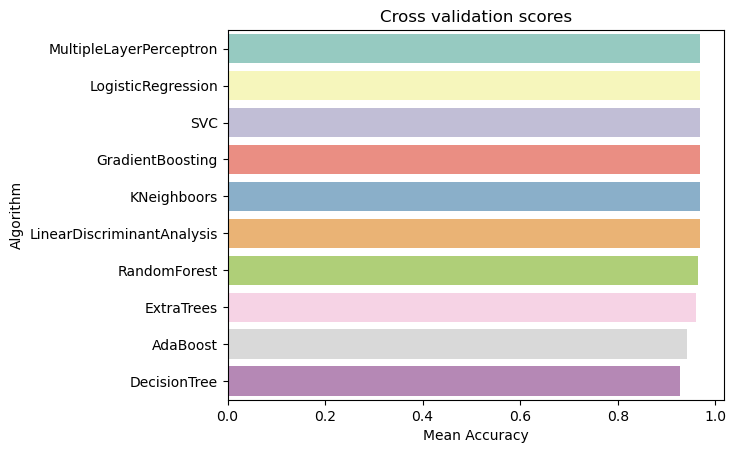

In [54]:
# Modeling step Test differents algorithms
random_state = 42
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

# Corrected barplot call
g = sns.barplot(x="CrossValMeans", y="Algorithm", data=cv_res, palette="Set3", orient="h",
                order=cv_res.sort_values("CrossValMeans", ascending=False)["Algorithm"])
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [55]:
cv_res
#I choose MultipleLayerPerceptron(top performer), LogisticRegression(low error),
# svc(robust), GradientBoosting(adds ensemble diversity), KNeighboors(distance based perspective)
##	MLP	LR	SVMC	GBC	KNC
#MLP	1.000000	0.996997	0.995711	0.996571	0.997856
#LR	0.996997	1.000000	0.996997	0.997000	0.998285
#SVMC	0.995711	0.996997	1.000000	0.995714	0.996999
#GBC	0.996571	0.997000	0.995714	1.000000	0.998714
#KNC	0.997856	0.998285	0.996999	0.998714	1.0000003

# but this gave a corr matrix that was too close to 1

#new choices: MultipleLayerPerceptron(top performer), LogisticRegression(low error),
# svc(robust), RandomForest(bagging vs boosting), ExtraTrees(randomization)

,CrossValMeans,CrossValerrors,Algorithm
0,0.968528,0.003444,SVC
1,0.927284,0.003950,DecisionTree
2,0.942993,0.005428,AdaBoost
3,0.963669,0.004718,RandomForest
4,0.960322,0.003902,ExtraTrees
5,0.968474,0.003592,GradientBoosting
6,0.968852,0.003638,MultipleLayerPerceptron
7,0.968366,0.003256,KNeighboors
8,0.968636,0.003005,LogisticRegression
9,0.967934,0.002897,LinearDiscriminantAnalysis


In [107]:
import joblib
import os
import joblib

models_path = path + 'models/'# Assuming models are in the same path as other data
print(models_path)

./dataset/models/


In [52]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import uniform, randint

# # Gradient boosting tunning

# GBC = GradientBoostingClassifier()

# # Define parameter distributions for RandomizedSearchCV
# gb_param_distributions = {
#     'loss': ["log_loss"],
#     'n_estimators': randint(100, 400),  # Random integer between 100 and 399
#     'learning_rate': uniform(0.001, 0.1), # Random float between 0.001 and 0.1
#     'max_depth': randint(3, 10),  # Random integer between 3 and 9
#     'min_samples_leaf': randint(50, 200), # Random integer between 50 and 199
#     'max_features': [0.3, 0.1, 'sqrt', 'log2'] # Can still include categorical options
# }

# # Use RandomizedSearchCV instead of GridSearchCV
# # n_iter: Number of parameter settings that are sampled. Increase for a more exhaustive search.
# rsGBC = RandomizedSearchCV(GBC, param_distributions=gb_param_distributions, n_iter=20, cv=kfold,
#                            scoring="accuracy", n_jobs=-1, verbose=1, random_state=42)

# rsGBC.fit(X_train,Y_train)

# GBC_best = rsGBC.best_estimator_

# # Best score
# rsGBC.best_score_

In [53]:
# GBC_best

In [108]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

file_path = models_path + 'rsSVMC.pkl'

if os.path.exists(file_path):
    rsSVMC = joblib.load(file_path)
    print(f"Successfully loaded {file_path}")
else:
    print(f"Model not found at {file_path}, computing algorithm")
    ### SVC classifier
    SVMC = SVC(probability=True)

    # Define parameter distributions for RandomizedSearchCV
    # Use uniform distribution for continuous parameters like gamma and C
    svc_param_distributions = {'kernel': ['rbf'],
                            'gamma': uniform(0.001, 1), # Random float between 0.001 and 1
                            'C': uniform(1, 1000)} # Random float between 1 and 1000

    # Use RandomizedSearchCV instead of GridSearchCV
    rsSVMC = RandomizedSearchCV(SVMC, param_distributions=svc_param_distributions,
                                n_iter=10, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1, random_state=42)

    rsSVMC.fit(X_train,Y_train)

    SVMC_best = rsSVMC.best_estimator_

    # Best score
    rsSVMC.best_score_

    joblib.dump(rsSVMC,file_path)
    if os.path.exists(file_path):
        print(f"Successfully wrote {file_path}")
    else:
        print(f"Error: Could not save model at {file_path}")

Successfully loaded ./dataset/models/rsSVMC.pkl


In [55]:
SVMC_best=rsSVMC.best_estimator_

In [109]:
### MLP classifier
from scipy.stats import randint


file_path = models_path + 'rsMLP.pkl'

if os.path.exists(file_path):
    rsMLP = joblib.load(file_path)
    print(f"Successfully loaded {file_path}")
else:
    print(f"Model not found at {file_path}, computing algorithm")
    MLP = MLPClassifier()

    # Define parameter distributions for RandomizedSearchCV
    mlp_param_distributions = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  # Sample from these tuples
        'activation': ['relu'],  # Sample from this list
        'solver': ['adam', 'sgd'],  # Sample from this list
        'learning_rate': ['constant', 'adaptive'],  # Sample from this list
        'learning_rate_init': uniform(0.001, 0.01),  # Random float between 0.001 and 0.01
        'alpha': uniform(0.0001, 0.001),  # Random float between 0.0001 and 0.001
        'batch_size': [32, 64],  # Sample from this list
        'max_iter': randint(200, 400)  # Random integer between 200 and 399 (increase range slightly for sampling)
    }

    # Use RandomizedSearchCV instead of GridSearchCV
    rsMLP = RandomizedSearchCV(MLP, param_distributions=mlp_param_distributions, n_iter=20, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1, random_state=42)

    rsMLP.fit(X_train,Y_train)

    MLP_best = rsMLP.best_estimator_

    # Best score
    rsMLP.best_score_

    joblib.dump(rsMLP,file_path)
    if os.path.exists(file_path):
        print(f"Successfully wrote {file_path}")
    else:
        print(f"Error: Could not save model at {file_path}")

Successfully loaded ./dataset/models/rsMLP.pkl


In [57]:
MLP_best=rsMLP.best_estimator_

In [58]:
# Linear regression tunning
file_path = models_path + 'rsLR.pkl'

if os.path.exists(file_path):
    rsLR = joblib.load(file_path)
    print(f"Successfully loaded {file_path}")
else:
    print(f"Model not found at {file_path}, computing algorithm")
    LR = LogisticRegression()

    # Define parameter distributions for RandomizedSearchCV
    # Ensure valid combinations of penalty and solver
    lr_param_distributions = {
        'penalty': ['l1', 'l2', 'elasticnet'], # Valid regularization penalties
        'C': uniform(0.01, 10), # Inverse of regularization strength
        'solver': ['liblinear', 'saga'], # Algorithm to use in the optimization problem
        'l1_ratio': uniform(0, 1) # The Elastic-Net mixing parameter, only for 'elasticnet' penalty
        }

    # To handle the penalty/solver compatibility with RandomizedSearchCV,
    # we can either manually specify valid combinations or use a solver that supports
    # the desired penalties. 'saga' supports 'l1', 'l2', and 'elasticnet'.
    # 'liblinear' supports 'l1' and 'l2'.

    # Let's define separate distributions for solvers to ensure compatibility
    lr_param_distributions = [
        # Combinations for 'liblinear' solver
        {'penalty': ['l1', 'l2'],
        'C': uniform(0.01, 10),
        'solver': ['liblinear']},
        # Combinations for 'saga' solver
        {'penalty': ['l1', 'l2', 'elasticnet'],
        'C': uniform(0.01, 10),
        'solver': ['saga'],
        'l1_ratio': uniform(0, 1)} # l1_ratio is only used with elasticnet
    ]


    # Use RandomizedSearchCV instead of GridSearchCV
    # n_iter: Number of parameter settings that are sampled. Increase for a more exhaustive search.
    rsLR = RandomizedSearchCV(LR, param_distributions=lr_param_distributions, n_iter=40, cv=kfold,
                            scoring="accuracy", n_jobs=-1, verbose=1, random_state=42)

    rsLR.fit(X_train,Y_train)

    LR_best = rsLR.best_estimator_

    # Best score
    rsLR.best_score_

    joblib.dump(rsLR,file_path)
    if os.path.exists(file_path):
        print(f"Successfully wrote {file_path}")
    else:
        print(f"Error: Could not save model at {file_path}")

Successfully loaded ./dataset/rsLR.pkl


In [59]:
LR_best =  rsLR.best_estimator_

In [60]:
# KNC = KNeighborsClassifier()

# # Define parameter distributions for RandomizedSearchCV
# knc_param_distributions = {
#     'n_neighbors': randint(1, 30),  # Number of neighbors to consider
#     'weights': ['uniform', 'distance'], # Weighting scheme
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], # Algorithm to compute neighbors
#     'p': [1, 2] # Power parameter for the Minkowski metric (1 for Manhattan, 2 for Euclidean)
# }

# # Use RandomizedSearchCV instead of GridSearchCV
# # n_iter: Number of parameter settings that are sampled. Increase for a more exhaustive search.
# rsKNC = RandomizedSearchCV(KNC, param_distributions=knc_param_distributions, n_iter=20, cv=kfold,
#                            scoring="accuracy", n_jobs=-1, verbose=1, random_state=42)

# rsKNC.fit(X_train,Y_train)

# KNC_best = rsKNC.best_estimator_

# # Best score
# rsKNC.best_score_

In [61]:
# KNC_best

In [62]:
# # Random forest tunning
# file_path = models_path + 'rsRF.pkl'

# if os.path.exists(file_path):
#     rsRF = joblib.load(file_path)
#     print(f"Successfully loaded {file_path}")
# else:
#     print(f"Model not found at {file_path}, computing algorithm")
#     RF = RandomForestClassifier()

#     # Define parameter distributions for RandomizedSearchCV
#     # Ensure valid combinations of penalty and solver
#     rf_param_distributions = {
#         'n_estimators': [100, 200, 300, 400, 500],  # Number of trees
#         'max_depth': [None, 10, 20, 30, 40, 50],   # Maximum depth of trees
#         'min_samples_split': [2, 5, 10],            # Minimum samples to split a node
#         'min_samples_leaf': [1, 2, 4],              # Minimum samples at a leaf
#         'max_features': ['sqrt', 'log2', None],     # Number of features to consider at each split
#         'bootstrap': [True, False]                   # Whether to use bootstrap samples
#         }


#     # Use RandomizedSearchCV instead of GridSearchCV
#     # n_iter: Number of parameter settings that are sampled. Increase for a more exhaustive search.
#     rsRF = RandomizedSearchCV(RF, param_distributions=rf_param_distributions, n_iter=40, cv=kfold,
#                             scoring="accuracy", n_jobs=-1, verbose=1, random_state=42)

#     rsRF.fit(X_train,Y_train)

#     RF_best = rsRF.best_estimator_

#     # Best score
#     rsRF.best_score_

#     joblib.dump(rsRF,file_path)
#     if os.path.exists(file_path):
#         print(f"Successfully wrote {file_path}")
#     else:
#         print(f"Error: Could not save model at {file_path}")

In [63]:
# RF_best

In [64]:
# # Extra trees tunning
# file_path = models_path + 'rsEXT.pkl'

# if os.path.exists(file_path):
#     rsEXT = joblib.load(file_path)
#     print(f"Successfully loaded {file_path}")
# else:
#     print(f"Model not found at {file_path}, computing algorithm")
#     EXT = ExtraTreesClassifier()

#     # Define parameter distributions for RandomizedSearchCV
#     # Ensure valid combinations of penalty and solver
#     ext_param_distributions = {
#        'n_estimators': randint(50, 500),  # Number of trees in the forest
#         'max_depth': randint(3, 30),       # Maximum depth of the tree
#         'min_samples_split': randint(2, 20), # Minimum number of samples required to split an internal node
#         'min_samples_leaf': randint(1, 20),  # Minimum number of samples required to be at a leaf node
#         'max_features': ['sqrt', 'log2', None],  # Number of features to consider at each split
#         'bootstrap': [True, False]          # Whether bootstrap samples are used
#         }


#     # Use RandomizedSearchCV instead of GridSearchCV
#     # n_iter: Number of parameter settings that are sampled. Increase for a more exhaustive search.
#     rsEXT = RandomizedSearchCV(EXT, param_distributions=ext_param_distributions, n_iter=40, cv=kfold,
#                             scoring="accuracy", n_jobs=-1, verbose=1, random_state=42)

#     rsEXT.fit(X_train,Y_train)

#     EXT_best = rsEXT.best_estimator_

#     # Best score
#     rsEXT.best_score_

#     joblib.dump(rsEXT,file_path)
#     if os.path.exists(file_path):
#         print(f"Successfully wrote {file_path}")
#     else:
#         print(f"Error: Could not save model at {file_path}")

In [65]:
# xgboost tunning


file_path = models_path + 'rsXGB.pkl' # Changed filename to reflect XGBoost

if os.path.exists(file_path):
    rsXGB = joblib.load(file_path)
    print(f"Successfully loaded {file_path}")
else:
    print(f"Model not found at {file_path}, computing algorithm")
    XGB = xgb.XGBClassifier(objective='binary:logistic', # Binary classification
                            eval_metric='logloss',       # Evaluation metric
                            use_label_encoder=False,     # Deprecated, set to False
                            random_state=42)

    # Define parameter distributions for RandomizedSearchCV for XGBoost
    xgb_param_distributions = {
        'n_estimators': randint(100, 1000),  # Number of boosting rounds
        'learning_rate': uniform(0.01, 0.3), # Step size shrinkage
        'max_depth': randint(3, 10),         # Maximum depth of a tree
        'min_child_weight': randint(1, 10),  # Minimum sum of instance weight (hessian) needed in a child
        'gamma': uniform(0, 0.5),            # Minimum loss reduction required to make a further partition
        'subsample': uniform(0.6, 0.4),      # Subsample ratio of the training instances
        'colsample_bytree': uniform(0.6, 0.4),# Subsample ratio of columns when constructing each tree
        'reg_alpha': uniform(0, 1),          # L1 regularization term on weights
        'reg_lambda': uniform(0, 1)         # L2 regularization term on weights
        }


    # Use RandomizedSearchCV instead of GridSearchCV
    # n_iter: Number of parameter settings that are sampled. Increase for a more exhaustive search.
    rsXGB = RandomizedSearchCV(XGB, param_distributions=xgb_param_distributions, n_iter=40, cv=kfold,
                            scoring="accuracy", n_jobs=-1, verbose=1, random_state=42)

    rsXGB.fit(X_train,Y_train)

    XGB_best = rsXGB.best_estimator_

    # Best score
    rsXGB.best_score_

    joblib.dump(rsXGB,file_path)
    if os.path.exists(file_path):
        print(f"Successfully wrote {file_path}")
    else:
        print(f"Error: Could not save model at {file_path}")

Successfully loaded ./dataset/rsXGB.pkl


In [66]:
XGB_best =  rsXGB.best_estimator_


In [67]:
# # lightGBM tunning
# from scipy.stats import uniform, randint

# file_path = models_path + 'rsLGBM.pkl' # Changed filename to reflect LightGBM

# if os.path.exists(file_path):
#     rsLGBM = joblib.load(file_path)
#     print(f"Successfully loaded {file_path}")
# else:
#     print(f"Model not found at {file_path}, computing algorithm")
#     LGBM = lgb.LGBMClassifier(objective='binary', # Binary classification
#                              metric='binary_logloss', # Evaluation metric
#                              random_state=42)

#     # Define parameter distributions for RandomizedSearchCV for LightGBM
#     lgbm_param_distributions = {
#         'n_estimators': randint(100, 1000),  # Number of boosting rounds
#         'learning_rate': uniform(0.01, 0.3), # Step size shrinkage
#         'num_leaves': randint(20, 150),      # Maximum tree leaves for base learners
#         'max_depth': randint(3, 15),         # Maximum tree depth for base learners
#         'min_child_samples': randint(20, 100), # Minimum number of data needed in a child
#         'subsample': uniform(0.6, 0.4),      # Subsample ratio of the training instances
#         'colsample_bytree': uniform(0.6, 0.4),# Subsample ratio of columns when constructing each tree
#         'reg_alpha': uniform(0, 1),          # L1 regularization term on weights
#         'reg_lambda': uniform(0, 1)         # L2 regularization term on weights
#         }


#     # Use RandomizedSearchCV instead of GridSearchCV
#     # n_iter: Number of parameter settings that are sampled. Increase for a more exhaustive search.
#     rsLGBM = RandomizedSearchCV(LGBM, param_distributions=lgbm_param_distributions, n_iter=40, cv=kfold,
#                             scoring="accuracy", n_jobs=-1, verbose=1, random_state=42)

#     rsLGBM.fit(X_train,Y_train)

#     LGBM_best = rsLGBM.best_estimator_

#     # Best score
#     rsLGBM.best_score_

#     joblib.dump(rsLGBM,file_path)
#     if os.path.exists(file_path):
#         print(f"Successfully wrote {file_path}")
#     else:
#         print(f"Error: Could not save model at {file_path}")

In [68]:
# file_path = models_path + 'rsLGBM.pkl'

# if os.path.exists(file_path):
#     rsLGBM = joblib.load(file_path)
#     print(f"Successfully loaded {file_path}")
# else:
#     print(f"Model not found at {file_path}, computing algorithm")
#     LGBM = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', 
#                               random_state=42, is_unbalance=True, verbose=2)

#     # Updated parameter distributions
#     lgbm_param_distributions = {
#         'n_estimators': randint(200, 1000),
#         'learning_rate': uniform(0.001, 0.1),
#         'num_leaves': randint(31, 200),
#         'max_depth': randint(5, 20),
#         'min_child_samples': randint(5, 50),
#         'subsample': uniform(0.6, 0.4),
#         'colsample_bytree': uniform(0.6, 0.4),
#         'reg_alpha': uniform(0, 1),
#         'reg_lambda': uniform(0, 1),
#         'min_split_gain': uniform(0, 0.1)
#     }

#     # Get the first fold's train and validation indices
#     for train_idx, valid_idx in kfold.split(X_train, Y_train):
#         # Extract validation set for the first fold
#         X_valid = X_train.iloc[valid_idx]  # Use .iloc for row indexing
#         Y_valid = Y_train.iloc[valid_idx] if isinstance(Y_train, pd.Series) else Y_train[valid_idx]
#         # Extract training set for this fold (if needed)
#         X_train_fold = X_train.iloc[train_idx]
#         Y_train_fold = Y_train.iloc[train_idx] if isinstance(Y_train, pd.Series) else Y_train[train_idx]
#         break  # Stop after the first fold

#     rsLGBM = RandomizedSearchCV(LGBM, param_distributions=lgbm_param_distributions, 
#                                 n_iter=40, cv=kfold, scoring="accuracy", 
#                                 n_jobs=-1, verbose=1, random_state=42)

#     rsLGBM.fit(X_train, Y_train,eval_set=[(X_valid, Y_valid)], eval_metric='binary_logloss')

#     LGBM_best = rsLGBM.best_estimator_
#     print("Best Parameters:", rsLGBM.best_params_)
#     print("Best Score:", rsLGBM.best_score_)

#     joblib.dump(rsLGBM, file_path)
#     if os.path.exists(file_path):
#         print(f"Successfully wrote {file_path}")
#     else:
#         print(f"Error: Could not save model at {file_path}")

In [ ]:
# import lightgbm as lgb
# from scipy.stats import uniform, randint
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import accuracy_score
# import joblib
# import os
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import ParameterSampler

# # Initialize StratifiedKFold
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Parameter distributions
# lgbm_param_distributions = {
#     'n_estimators': randint(200, 1000),
#     'learning_rate': uniform(0.001, 0.1),
#     'num_leaves': randint(31, 200),
#     'max_depth': randint(5, 20),
#     'min_child_samples': randint(5, 50),
#     'subsample': uniform(0.6, 0.4),
#     'colsample_bytree': uniform(0.6, 0.4),
#     'reg_alpha': uniform(0, 1),
#     'reg_lambda': uniform(0, 1),
#     'min_split_gain': uniform(0, 0.1)
# }

# # Sample 40 hyperparameter combinations
# param_list = list(ParameterSampler(lgbm_param_distributions, n_iter=40, random_state=42))

# file_path = models_path + 'rsLGBM.pkl'

# if os.path.exists(file_path):
#     rsLGBM = joblib.load(file_path)
#     print(f"Successfully loaded {file_path}")
# else:
#     print(f"Model not found at {file_path}, computing algorithm")
    
#     best_score = -np.inf
#     best_params = None
#     best_model = None
#     scores = []

#     # Iterate over hyperparameter combinations
#     for params in param_list:
#         fold_scores = []
        
#         # Perform 5-fold cross-validation
#         for train_idx, valid_idx in kfold.split(X_train, Y_train):
#             # Extract train and validation sets for this fold
#             X_train_fold = X_train.iloc[train_idx]
#             Y_train_fold = Y_train.iloc[train_idx] if isinstance(Y_train, pd.Series) else Y_train[train_idx]
#             X_valid_fold = X_train.iloc[valid_idx]
#             Y_valid_fold = Y_train.iloc[valid_idx] if isinstance(Y_train, pd.Series) else Y_train[valid_idx]

#             # Initialize LightGBM with current parameters
#             LGBM = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', 
#                                       random_state=42, is_unbalance=True, verbose=2, **params)

#             # Fit model with early stopping
#             LGBM.fit(X_train_fold, Y_train_fold, 
#                      eval_set=[(X_valid_fold, Y_valid_fold)], 
#                      eval_metric='binary_logloss', 
#                      callbacks=[lgb.early_stopping(stopping_rounds=10)])
                     

#             # Evaluate on validation fold
#             Y_pred = LGBM.predict(X_valid_fold)
#             fold_score = accuracy_score(Y_valid_fold, Y_pred)
#             fold_scores.append(fold_score)

#         # Average score across folds for this parameter set
#         avg_score = np.mean(fold_scores)
#         scores.append(avg_score)
        
#         # Update best model if current score is better
#         if avg_score > best_score:
#             best_score = avg_score
#             best_params = params
#             best_model = LGBM

#     print("Best Parameters:", best_params)
#     print("Best Cross-Validation Accuracy:", best_score)

#     # Save the best model
#     joblib.dump(best_model, file_path)
#     if os.path.exists(file_path):
#         print(f"Successfully wrote {file_path}")
#     else:
#         print(f"Error: Could not save model at {file_path}")

Successfully loaded ./dataset/rsLGBM.pkl


In [77]:
import os
import joblib
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import randint, uniform

# Initialize StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Parameter distributions
lgbm_param_distributions = {
    'n_estimators': randint(200, 1000),
    'learning_rate': uniform(0.001, 0.1),
    'num_leaves': randint(31, 200),
    'max_depth': randint(5, 20),
    'min_child_samples': randint(5, 50),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'min_split_gain': uniform(0, 0.1)
}

file_path = models_path + 'rsLGBM.pkl'

if os.path.exists(file_path):
    rsLGBM = joblib.load(file_path)
    print(f"Successfully loaded {file_path}")
else:
    print(f"Model not found at {file_path}, computing algorithm")
    
    # Initialize LightGBM Classifier
    LGBM = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', 
                              random_state=42, is_unbalance=True, verbose=-1)

    # Use RandomizedSearchCV
    rsLGBM = RandomizedSearchCV(
        estimator=LGBM, 
        param_distributions=lgbm_param_distributions, 
        n_iter=10, 
        cv=kfold,
        scoring="accuracy", 
        n_jobs=-1, 
        verbose=1, 
        random_state=42
    )

    # Fit the model with early stopping
    rsLGBM.fit(
        X_train, 
        Y_train,
        eval_set=[(X_train, Y_train)], 
        eval_metric='binary_logloss',
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )

    # Get the best estimator
    LGBM_best = rsLGBM.best_estimator_

    # Print best parameters and score
    print("Best Parameters:", rsLGBM.best_params_)
    print("Best Cross-Validation Accuracy:", rsLGBM.best_score_)

    # Save the model
    joblib.dump(rsLGBM, file_path)
    if os.path.exists(file_path):
        print(f"Successfully wrote {file_path}")
    else:
        print(f"Error: Could not save model at {file_path}")

Model not found at ./dataset/rsLGBM.pkl, computing algorithm
Fitting 5 folds for each of 10 candidates, totalling 50 fits


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.101211
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.0990917
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.100469
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.101459
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[134]	valid_0's binary_logloss: 0.112516
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.102031

/home/alexandru/.conda/envs/ml_competitions/lib/python3.11/site-packages/lightgbm/callback.py:347: UserWarning: Only training set found, disabling early stopping.
  _log_warning("Only training set found, disabling early stopping.")


Best Parameters: {'colsample_bytree': np.float64(0.679486272613669), 'learning_rate': np.float64(0.00155221171236024), 'max_depth': 15, 'min_child_samples': 21, 'min_split_gain': np.float64(0.071134195274865), 'n_estimators': 618, 'num_leaves': 63, 'reg_alpha': np.float64(0.6059599747810114), 'reg_lambda': np.float64(0.926300878513349), 'subsample': np.float64(0.8604308102007778)}
Best Cross-Validation Accuracy: 0.9684195078158929
Successfully wrote ./dataset/rsLGBM.pkl


In [78]:
LGBM_best = rsLGBM.best_estimator_

/home/alexandru/.conda/envs/ml_competitions/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (387) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alexandru/.conda/envs/ml_competitions/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (387) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alexandru/.conda/envs/ml_competitions/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (387) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alexandru/.conda/envs/ml_competitions/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:54:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



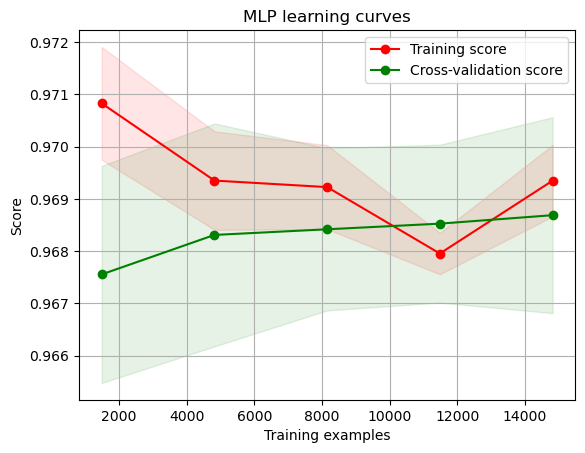

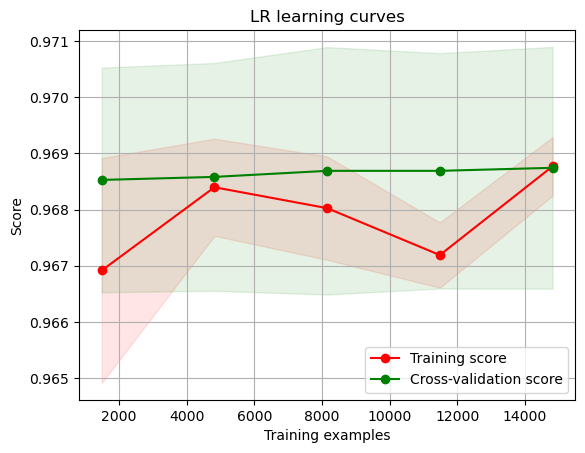

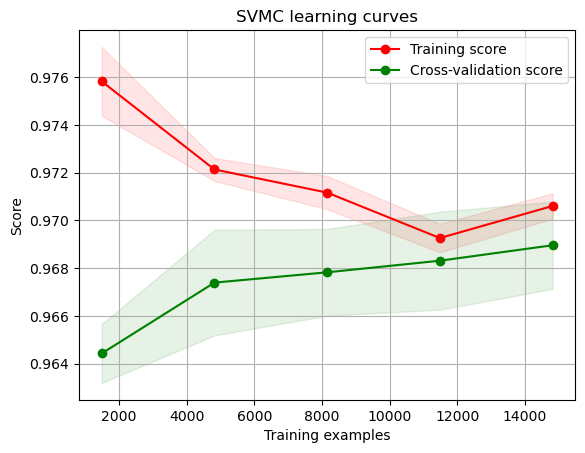

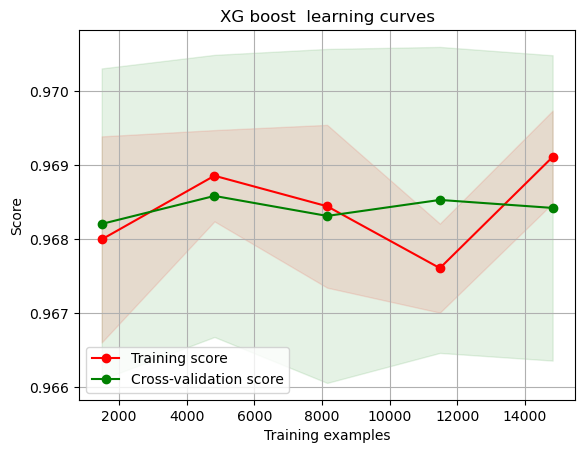

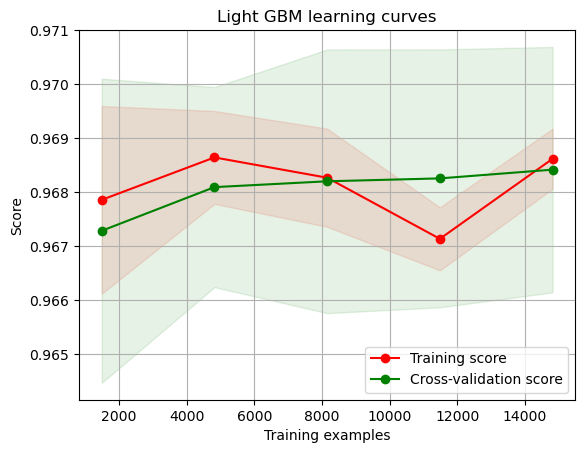

In [79]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(rsMLP.best_estimator_,"MLP learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(rsLR.best_estimator_,"LR learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(rsSVMC.best_estimator_,"SVMC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(rsXGB.best_estimator_,"XG boost  learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(rsLGBM.best_estimator_,"Light GBM learning curves",X_train,Y_train,cv=kfold)

<h2>Train SGD Classifier</h2>

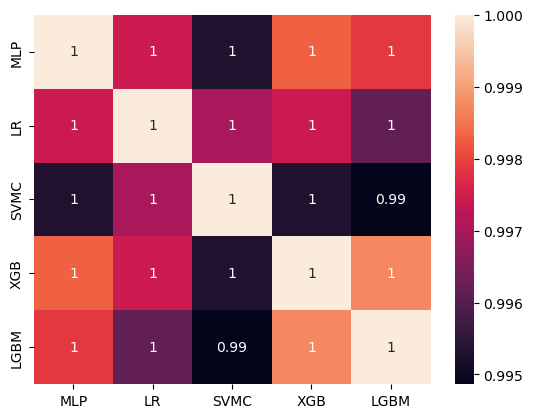

In [80]:
test_Extrovert_MLP = pd.Series(MLP_best.predict(X_test), name="MLP")
test_Extrovert_LR = pd.Series(LR_best.predict(X_test), name="LR")
test_Extrovert_SVMC = pd.Series(SVMC_best.predict(X_test), name="SVMC")
test_Extrovert_XGB = pd.Series(XGB_best.predict(X_test), name="XGB")
test_Extrovert_LGBM = pd.Series(LGBM_best.predict(X_test), name="LGBM")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Extrovert_MLP,test_Extrovert_LR,test_Extrovert_SVMC,test_Extrovert_XGB, test_Extrovert_LGBM],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)
# mabe too much similariy

In [110]:
file_path = models_path + 'ensemble.pkl'

if os.path.exists(file_path):
    stackingC = joblib.load(file_path)
    print(f"Successfully loaded {file_path}")
else:
    print(f"Model not found at {file_path}, computing algorithm")

    #implement stacking
    from sklearn.ensemble import StackingClassifier
    stackingC = StackingClassifier(estimators=[('mlp', MLP_best), ('lr', LR_best),
    ('svc', SVMC_best), ('xgb', XGB_best), ('lgbm',LGBM_best)],  final_estimator=LogisticRegression(), n_jobs=-1)

    stackingC = stackingC.fit(X_train, Y_train)

    # Save the trained stacking classifier
    file_path = models_path + 'ensemble.pkl'
    joblib.dump(stackingC, file_path)

    # Verify that the model has been saved
    if os.path.exists(file_path):
        print(f"Successfully saved the ensemble model to {file_path}")
    else:
        print(f"Error: Could not save the ensemble model at {file_path}")

Successfully loaded ./dataset/models/ensemble.pkl


In [85]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Get cross-validated predictions for the stacking classifier
Y_train_pred_stacking = cross_val_predict(stackingC, X_train, Y_train, cv=kfold)

# Calculate metrics for the stacking classifier
accuracy_stacking = accuracy_score(Y_train, Y_train_pred_stacking)
precision_stacking = precision_score(Y_train, Y_train_pred_stacking, pos_label=1)
recall_stacking = recall_score(Y_train, Y_train_pred_stacking, pos_label=1)
f1_stacking = f1_score(Y_train, Y_train_pred_stacking, pos_label=1)
conf_matrix_stacking = confusion_matrix(Y_train, Y_train_pred_stacking)


print("Metrics for Stacking Classifier:")
print(f"Accuracy: {accuracy_stacking:.4f}")
print(f"Precision: {precision_stacking:.4f}")
print(f"Recall: {recall_stacking:.4f}")
print(f"F1-score: {f1_stacking:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_stacking)

/home/alexandru/.conda/envs/ml_competitions/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:34:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[16:37:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[16:37:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[16:37:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[16:37:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[16:37:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

/home/alexandru/.conda/envs/ml_competitions/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:40:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(

Metrics for Stacking Classifier:
Accuracy: 0.9686
Precision: 0.9771
Recall: 0.9805
F1-score: 0.9788

Confusion Matrix:
[[ 4510   315]
 [  267 13432]]


/home/alexandru/.conda/envs/ml_competitions/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:02:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[17:04:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[17:04:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[17:04:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[17:04:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[17:04:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

/home/alexandru/.conda/envs/ml_competitions/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:07:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(

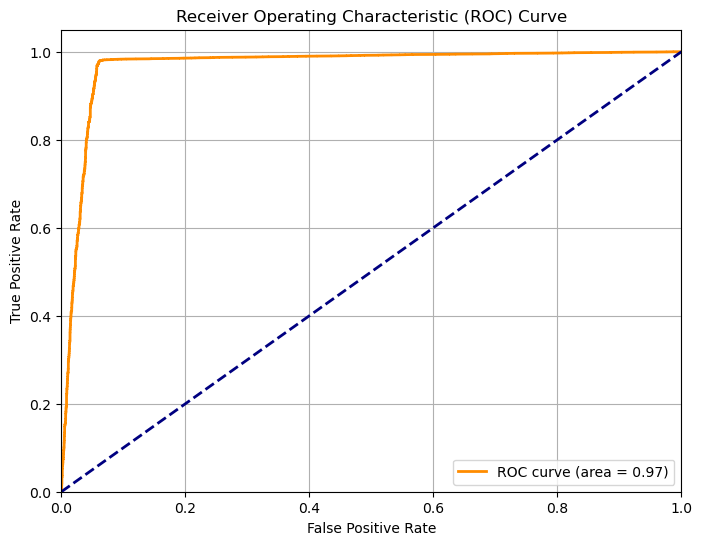

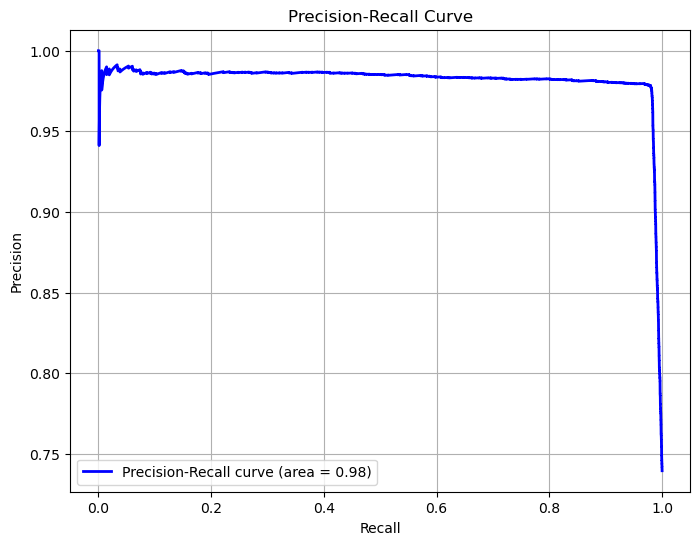

In [87]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Get cross-validated probability predictions for the positive class (Extrovert)
Y_scores_stacking = cross_val_predict(stackingC, X_train, Y_train, cv=kfold, method="predict_proba")[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_train, Y_scores_stacking)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_train, Y_scores_stacking)
pr_auc = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In [88]:
test_Extrovert = pd.Series(stackingC.predict(X_test), name="Personality")

test_Extrovert

0       1
1       0
2       1
3       1
4       0
       ..
6170    1
6171    0
6172    1
6173    1
6174    0
Name: Personality, Length: 6175, dtype: int64

In [89]:
X_test = X_test[[]]
# test_Extrovert.values
X_test = X_test.assign(Personality=test_Extrovert.values)
X_test.Personality.replace({0:'Introvert',1:'Extrovert'},inplace=True)

/tmp/ipykernel_4946/3327918901.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test.Personality.replace({0:'Introvert',1:'Extrovert'},inplace=True)


In [90]:
X_test.index.name = 'id'
X_test

,Personality
id,
18524,Extrovert
18525,Introvert
18526,Extrovert
18527,Extrovert
18528,Introvert
...,...
24694,Extrovert
24695,Introvert
24696,Extrovert


In [111]:
X_test.to_csv(path + 'submission.csv')